## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed_value = 777
random.seed(seed_value)
np.random.seed(seed_value)

labels = pd.read_csv('data/labels.csv')

train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='data/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=seed_value,
)

features, ages = next(train_datagen_flow)

Found 7591 validated image filenames.


## EDA

(32, 224, 224, 3)
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


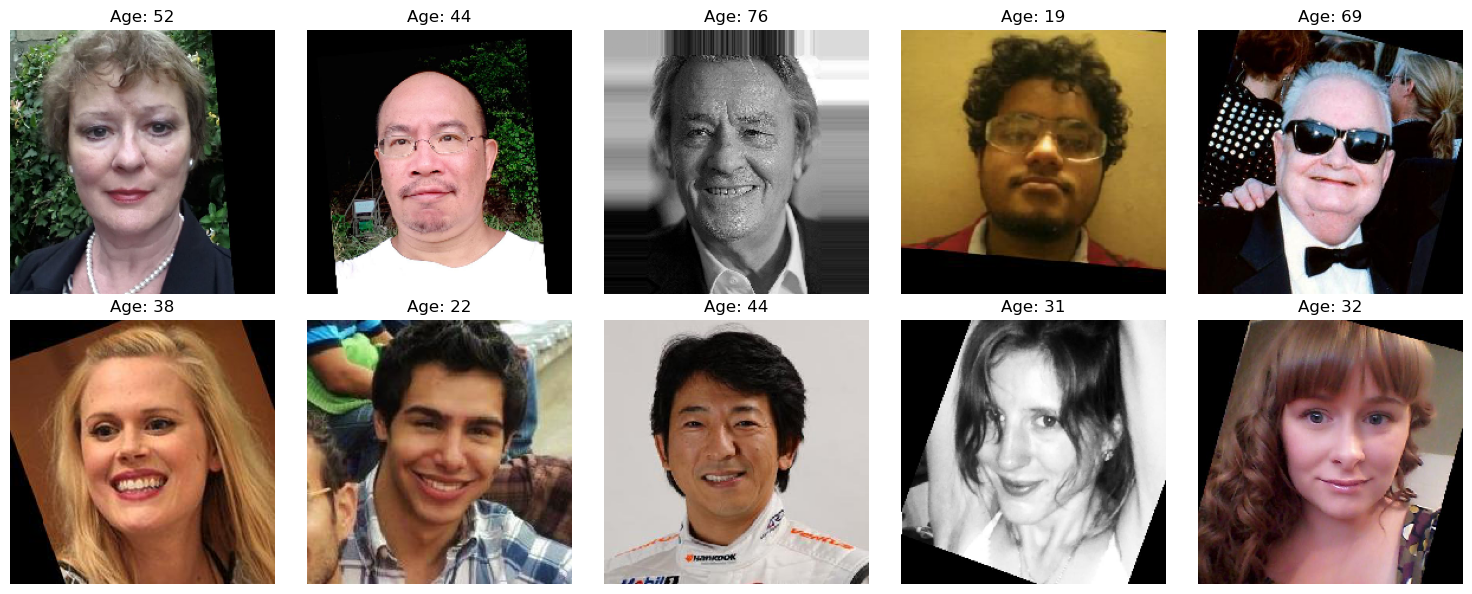

In [2]:
print(features.shape)
print(labels.describe())

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(features[i])
    axes[i].set_title(f'Age: {ages[i]:.0f}')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

### Findings

**- Age distribution for our data set is as follows: roughly 25% of our data wouldn't classify as old enough to buy alcohol (Q1, 25% of values fall below 21). (min=1, max=100), the mean sits around 31 years of age, and 75% of our dataset is 41 years or younger.**

**- The 10 images displayed from one of our batches has one person under 21 (20% of the batch sample), this loosely resembles our dataset as a whole (25% under 21 years of age).**

**- There's a class imbalance in the context of having the ability to buy alcohol, with about 75% of our dataset classifying as 1 (of age), while roughly 25% of the dataset classifies as 0 (not of age).**

**- As far as picture clarity, the photos printed are clear and have good lighting.**

**- With 7.9k images, I believe transfer learning will be the best course of action for this task. Utilizing an already established model with learned features will improve our accuracy, save time, and computational resources.**

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
def load_train(df_train, path):
    
    """
    It loads the train part of dataset from path
    """

    train_datagen = ImageDataGenerator(rescale=1/255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=seed_value,
    )

    return train_gen_flow

In [5]:
def load_test(df_test, path):
    
    """
    It loads the validation/test part of dataset from path
    """

    test_datagen = ImageDataGenerator(rescale=1/255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=seed_value,
    )

    return test_gen_flow

In [6]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [7]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=1)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [8]:
# prepare a script to run on the GPU platform

init_str = """
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

main_execution_str="""
# ----- imports -----
import random
import os

# ----- reproducibility -----
seed_value = 777
random.seed(seed_value)
np.random.seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ----- data splitting -----
data_path = 'data/'
full_labels = pd.read_csv(data_path + 'labels.csv')
df_train, df_test = train_test_split(full_labels, test_size=.25, random_state=seed_value)
print(f'Total images: {len(full_labels)}')
print(f'Train images: {len(df_train)} (75%)')
print(f'Test images: {len(df_test)} (25%)')

# ----- load data gen -----
print('Loading data generators..')
train_generator = load_train(df_train, data_path)
test_generator = load_test(df_test, data_path)
print(f'Train batches: {len(train_generator)}, Test batches: {len(test_generator)}')

# ----- model creation -----
input_shape=(224, 224, 3)
print(f'Creating model with {input_shape} input shape..')
model = create_model(input_shape)
print('Model initiation completed.')

# ----- model training -----
print('Training model..')
trained_model = train_model(model, train_generator, test_generator, epochs=20)
print('Traiing finished.')
"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    f.write(main_execution_str)
    f.write('\n')

print("The script 'run_model_on_gpu.py' is complete and ready to run.")

The script 'run_model_on_gpu.py' is complete and ready to run.


**- Code and model are way too big to run without GPU integration, **

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454

Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481

Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192

Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332

Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359

Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239

Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529

Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629

Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866

Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591

Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467

Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401

Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841

Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304

Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training